# Gaussian Regression

## Definition

A Gaussian process (GP) is a stochastic process whose joint distribution is completely specified by a mean function and a covariance function. The covariance function $k(s,t)$ defines the joint distribution of $X(s)$ and $X(t)$:

$$
X(s) \sim \mathcal{GP}(0, k)
$$

where $k(s,t)$ is a deterministic function.
The Gaussian process regression model is defined as:

$$
r_t = X(t) + \epsilon_t, \quad X(t) \sim \mathcal{GP}(0, k), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)
$$

where $\epsilon_t$ represents independent Gaussian observation noise with variance $\sigma_\epsilon^2$.

## Kernel: `Matern 3/2`

`Matern 3/2` kernel is a special case of the Matern kernel family with smoothness parameter $\nu=3/2$:

$$
\begin{aligned}
k_v(s,t)&=\sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu}\tau}{\ell}\right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{\ell}\right)\\[6pt]
k_\frac{1}{2}(s,t)&=\sigma^2\exp\left(-\frac{\tau}{\ell}\right)\\[6pt]
k_\frac{3}{2}(s,t)&=\sigma^2\left(1+\frac{\sqrt{3}\tau}{\ell}\right)\exp\left(-\frac{\sqrt{3}\tau}{\ell}\right)\\[6pt]
k_\frac{5}{2}(s,t)&=\sigma^2\left(1+\frac{\sqrt{5}\tau}{\ell}+\frac{5\tau^2}{3\ell^2}\right)\exp\left(-\frac{\sqrt{5}\tau}{\ell}\right)\\[6pt]
k_{\infty}(s,t)&=\sigma^2\exp\left(-\frac{\tau^2}{2\ell^2}\right)
\end{aligned}
$$

where $\tau=|s-t|$ and the variance is $\sigma^2$.

| Kernel        | Smoothness          | Model Interpretation                              | Suitable Scenarios & Reasons                                                    |
|---------------|---------------------|----------------------------------------------------|----------------------------------------------------------------------------------|
| Matérn-1/2    | Not differentiable  | Sharp, jumpy paths (like Ornstein–Uhlenbeck)       | High-frequency/noisy signals — captures rapid fluctuation and mean-reversion   |
| Matérn-3/2    | Once differentiable | Bumpy but smooth with local reversions             | Short-term trends with local reversals — captures momentum and bounce effects   |
| Matérn-5/2    | Twice differentiable| Smoother trends, gently oscillating trajectories   | Medium-horizon forecasting — smoother continuation with moderate reversion      |
| RBF          | Infinitely smooth   | Very smooth, almost deterministic functions        | Long-term or structural trend modeling — assumes strong smoothness and inertia  |

Several studies have found the `Matern 3/2` kernel to be well-suited for modeling financial log returns:

> Rizvi (2018) and Liu, Kiskin, and Roberts (2020) demonstrated that a Matérn 3/2
kernel is a good choice of covariance function for noisy financial data, which tend to
be highly nonsmooth and not infinitely differentiable.

If we define the normalized lag as $\kappa=\tau/\ell$, the auto-correlation is given by:

$$
\frac{C_X(\tau)}{C_X(0)}=\left(1+\sqrt{3}\kappa\right)\exp\left(-\sqrt{3}\kappa\right)
$$

This expression reveals that autocorrelation decays as the lag increases. Notably, the autocorrelation drops to approximately 0.5 at $\kappa\approx0.97$, and further declines to around 0.1 when $\kappa\approx2.25$.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.kernels import Matern32


def simulate_white_noise(n, M=1000, variance=1.0):
    """
    Returns:
        np.ndarray: shape (M, n) sample paths
    """
    std = np.sqrt(variance)
    return np.random.normal(loc=0., scale=std, size=(M, n))


def simulate_matern32_gp(n, M=1000, lengthscale=0.2, variance=1.0, jitter=1e-6):
    """
    Simulate M samples from a GP with Matern 3/2 kernel.
    
    Args:
        n (int): number of time points
        M (int): number of sample paths
        lengthscale (float): kernel lengthscale
        variance (float): kernel variance
        jitter (float): numerical stability

    Returns:
        np.ndarray: shape (M, n) sample paths
    """
    X = np.linspace(0, 1, n).reshape(-1, 1)
    
    # Only compute K once
    kernel = Matern32(lengthscales=lengthscale, variance=variance)
    K = kernel(tf.convert_to_tensor(X), full_cov=True).numpy()
    K += jitter * np.eye(n)  # for numerical stability

    # Use numpy's batch multivariate normal sampling
    L = np.linalg.cholesky(K)  # K = L @ L.T
    Z = np.random.randn(M, n)  # standard normal
    samples = Z @ L.T  # shape (M, n)
    return samples


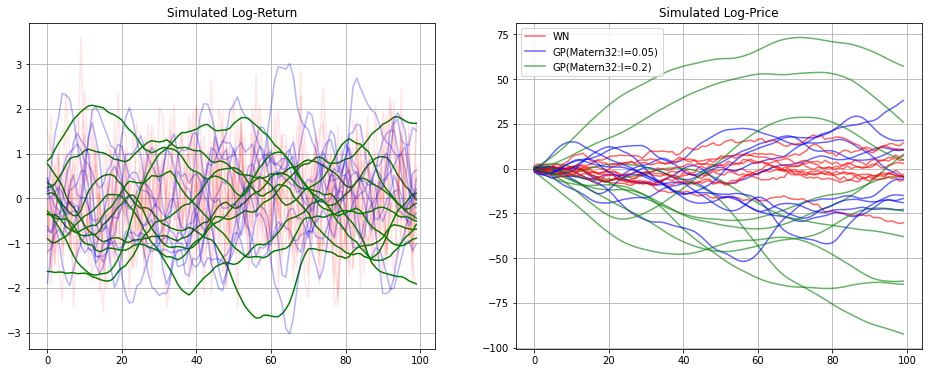

In [4]:
n = 100
xi1 = 0.05
xi2 = 0.2
var = 1.0

M = 10

wn = simulate_white_noise(n, M, var)
gp1 = simulate_matern32_gp(n, M, xi1, var)
gp2 = simulate_matern32_gp(n, M, xi2, var)

fig, axs = plt.subplots(1, 2)
lhs = None
for j in range(M):
    h1, = axs[1].plot(wn[j].cumsum(), color='red', alpha=0.6)
    h2, = axs[1].plot(gp1[j].cumsum(), color='blue', alpha=0.6)
    h3, = axs[1].plot(gp2[j].cumsum(), color='green', alpha=0.6)
    
    axs[0].plot(wn[j], color='red', alpha=0.1)
    axs[0].plot(gp1[j], color='blue', alpha=0.3)
    axs[0].plot(gp2[j], color='green', alpha=1.0)
    if lhs is None:
        lhs = [h1, h2, h3]

axs[0].grid(True)
axs[0].set_title('Simulated Log-Return')
axs[1].grid(True)
axs[1].legend(lhs, ['WN', f'GP(Matern32:l={xi1})', f'GP(Matern32:l={xi2})'], loc='upper left')
axs[1].set_title('Simulated Log-Price')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

## Estimation

A common approach for estimating Gaussian process regression models is to minimize the **negative log-marginal likelihood (NLML)**. The NLML is defined as:

$$
\mathcal{L}_{\text{NLML}}(\theta) = \frac{1}{2} \mathbf{r}^\top V^{-1} \mathbf{r} + \frac{1}{2} \log \det(V) + \frac{n}{2} \log 2\pi
$$

where $V = K + \sigma_\epsilon^2 I$ is the covariance matrix of the observations, with $K$ denoting the kernel matrix and $\sigma_\epsilon^2$ the observation noise variance.

In [6]:
from mom_trans.changepoint_detection import fit_matern_kernel

# create GP series and Noise series
sigma = 1.0
ell = 0.2
sigma_epsilon = 0.8

n = 1000
M = 1

gp_path = simulate_matern32_gp(n, M, ell, sigma**2)
noise_path = simulate_white_noise(n, M, sigma_epsilon**2)

X = np.linspace(0, 1, n)
cases = [
    # case 1. fit with white noise
    (f'noise(sigma_e={sigma_epsilon})', pd.DataFrame({'X': X, 'Y': noise_path[0]})),
    
    # case 2. fit with pure gp series
    (f'GP(ell={ell},sigma={sigma})', pd.DataFrame({'X': X, 'Y': gp_path[0]})),
    
    # case 3. fit with gp series and noise
    (f'GP(ell={ell},sigma={sigma},sigma_e={sigma_epsilon})', pd.DataFrame({'X': X, 'Y': (gp_path[0] + noise_path[0])})),
]
tbl = []
from time import time_ns
t0 = time_ns()
for label, df in cases:
    ll, params = fit_matern_kernel(df)
    row = [label, params['kM_lengthscales'], params['kM_variance'], params['kM_likelihood_variance'], ll]
    tbl.append(row)
t1 = time_ns()
print(f'time-cost with {n} samples: {(t1-t0)/1e9:.2f}s')

from tabulate import tabulate
print(tabulate(tbl, headers=['Model', 'Lengthscale', 'Variance', 'Noise Variance', 'NLML'], floatfmt=('.0f', '.2f', '.2f', '.2f', '.2f')))

time-cost with 1000 samples: 4.41s
Model                                Lengthscale    Variance    Noise Variance      NLML
---------------------------------  -------------  ----------  ----------------  --------
noise(sigma_e=0.8)                         21.70        0.00              0.65   1200.96
GP(ell=0.2,sigma=1.0)                       0.19        0.93              0.00  -4594.38
GP(ell=0.2,sigma=1.0,sigma_e=0.8)           0.26        1.15              0.65   1222.61


## Change Point Kernel

Lloyd et al. (2014), in their paper *"Automatic Construction and Natural-Language Description of Nonparametric Regression Models"*, proposed a **changepoint kernel** by introducing a sigmoid-based weighting function:

$$
\sigma(x) = \frac{1}{1 + e^{-a(x - c)}}
$$

where:

$$
\begin{cases}
\sigma(x) \rightarrow 0 & \quad \text{as} \quad x \ll c \\[6pt]
\sigma(x) \rightarrow 1 & \quad \text{as} \quad x \gg c
\end{cases}
$$

This sigmoid acts as a **soft indicator** of whether an input is before or after the changepoint \( c \). Using this, the changepoint kernel is defined as:

$$
k_{\text{CP}}(s, t) = (1 - \sigma(s))(1 - \sigma(t))\,k_1(s, t) + \sigma(s)\sigma(t)\,k_2(s, t)
$$

Assuming \( s < t \) for convenience, we observe the following asymptotic behavior:

$$
\begin{cases}
(1 - \sigma(s))(1 - \sigma(t)) \rightarrow 1,\quad \sigma(s)\sigma(t) \rightarrow 0 & \text{if } s \ll c \text{ and } t \ll c \\[6pt]
(1 - \sigma(s))(1 - \sigma(t)) \rightarrow 0,\quad \sigma(s)\sigma(t) \rightarrow 1 & \text{if } s \gg c \text{ and } t \gg c \\[6pt]
(1 - \sigma(s))(1 - \sigma(t)) \rightarrow 0,\quad \sigma(s)\sigma(t) \rightarrow 0 & \text{if } s \ll c \text{ and } t \gg c
\end{cases}
$$

Therefore:

- If both $s$ and $t$ lie **before** the changepoint $c$, the kernel reduces to $k_1(s, t)$;
- If both $s$ and $t$ lie **after** the changepoint $c$, the kernel reduces to $k_2(s, t)$;
- If $s$ and $t$ lie on **opposite sides** of the changepoint, the kernel value tends toward **zero**, reflecting **independence** between regimes.

This construction captures the intuition that a changepoint at $c$ introduces a structural break: correlations between observations on opposite sides of the changepoint are suppressed, while each regime retains its own covariance structure.



In [11]:
from mom_trans.changepoint_detection import fit_changepoint_kernel

n1 = 400
ell1 = 0.05
sigma1 = 2.0

n2 = 600
ell2 = 0.3
sigma2 = 0.8

sigma_e = 0.5
M = 1

gp_path1 = simulate_matern32_gp(n1, M, ell1, sigma1**2)[0]
gp_path2 = simulate_matern32_gp(n2, M, ell2, sigma2**2)[0]
noise_path = simulate_white_noise(n1+n2, M, sigma_e**2)[0]

y = np.concatenate([gp_path1, gp_path2]) + noise_path
X = np.linspace(0, 1, n1+n2)

from time import time_ns
t0 = time_ns()
loc, c1ll, c1_params = fit_changepoint_kernel(pd.DataFrame({'X': X, 'Y': y}))
t1 = time_ns()
print(f'time-cost with {n1+n2} samples: {(t1-t0)/1e9:.2f}s')

tbl = [
    [f'ell={ell1:.2f},variance={sigma1**2:.2f}', c1_params['k1_lengthscale'], c1_params['k1_variance']],
    [f'ell={ell2:.2f},variance={sigma2**2:.2f}', c1_params['k2_lengthscale'], c1_params['k2_variance']],
]
print(tabulate(tbl, headers=['Kernel', 'Lengthscale', 'Variance'], floatfmt=('.0f', '.2f', '.2f')))
print(f'noise_variance: {sigma_e**2:.2f}', f'likelihood_variance: {c1_params['kC_likelihood_variance']:.2f}')
print(f'change_point: {n1/(n1+n2):.2f}', f'change_point_estimated: {loc:.2f}')
print(f'steepness: {c1_params['kC_steepness']:.2f}')

time-cost with 1000 samples: 12.24s
Kernel                    Lengthscale    Variance
----------------------  -------------  ----------
ell=0.05,variance=4.00           0.02        8.23
ell=0.30,variance=0.64           0.44        0.88
noise_variance: 0.25 likelihood_variance: 0.26
change_point: 0.40 change_point_estimated: 0.40
steepness: 566.03


In [14]:
m1ll, m1_params = fit_matern_kernel(pd.DataFrame({'X': X, 'Y': y}))

y2m = simulate_matern32_gp(n1+n2, M, ell1, sigma1**2)[0] + noise_path
loc, c2ll, c2_params = fit_changepoint_kernel(pd.DataFrame({'X': X, 'Y': y2m}))
m2ll, m2_params = fit_matern_kernel(pd.DataFrame({'X': X, 'Y': y2m}))

def score(Cl, Ml):
    normalized_nlml = Cl - Ml
    return 1 - 1 / (np.mean(np.exp(-normalized_nlml)) + 1)

print(f'data1(CP kernel)    : CLL = {c1ll:.01f}, MLL = {m1ll:.01f}, score = {score(c1ll, m1ll):.03f}')
print(f'data2(Matern kernel): CLL = {c2ll:.01f}, MLL = {m2ll:.01f}, score = {score(c2ll, m2ll):.03f}')

data1(CP kernel)    : CLL = 860.0, MLL = 940.9, score = 1.000
data2(Matern kernel): CLL = 856.6, MLL = 856.6, score = 0.500
